Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST_cln.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (187248, 28, 28) (187248,)
Validation set (8905, 28, 28) (8905,)
Test set (8680, 28, 28) (8680,)


In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels, engine='tf'):
    if engine == 'tf':
        dataset = dataset.reshape(
            (-1, image_size, image_size, num_channels)).astype(np.float32)
    elif engine == 'th':
        dataset = dataset.reshape(
            (-1, num_channels, image_size, image_size)).astype(np.float32)
    else:
        raise ValueError("engine must be 'tf' or 'th'")
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels, engine='th')
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels, engine='th')
test_dataset, test_labels = reformat(test_dataset, test_labels, engine='th')
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (187248, 1, 28, 28) (187248, 10)
Validation set (8905, 1, 28, 28) (8905, 10)
Test set (8680, 1, 28, 28) (8680, 10)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [4]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, num_channels, depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [patch_size, patch_size, depth, depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [num_hidden, num_labels], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases
  
    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.925714
Minibatch accuracy: 6.2%
Validation accuracy: 10.3%
Minibatch loss at step 50: 1.478131
Minibatch accuracy: 62.5%
Validation accuracy: 46.0%
Minibatch loss at step 100: 0.970941
Minibatch accuracy: 75.0%
Validation accuracy: 74.0%
Minibatch loss at step 150: 0.646869
Minibatch accuracy: 81.2%
Validation accuracy: 73.2%
Minibatch loss at step 200: 0.886329
Minibatch accuracy: 68.8%
Validation accuracy: 76.4%
Minibatch loss at step 250: 1.022261
Minibatch accuracy: 81.2%
Validation accuracy: 77.1%
Minibatch loss at step 300: 0.832114
Minibatch accuracy: 81.2%
Validation accuracy: 77.3%
Minibatch loss at step 350: 0.811988
Minibatch accuracy: 87.5%
Validation accuracy: 78.2%
Minibatch loss at step 400: 0.398773
Minibatch accuracy: 93.8%
Validation accuracy: 79.5%
Minibatch loss at step 450: 0.613940
Minibatch accuracy: 81.2%
Validation accuracy: 79.1%
Minibatch loss at step 500: 0.310455
Minibatch accuracy: 93.8%
Validation accuracy: 79.0%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [7]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

# Input data.
tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
tf_valid_dataset = tf.constant(valid_dataset)
tf_test_dataset = tf.constant(test_dataset)

# Variables.
layer1_weights = tf.Variable(tf.truncated_normal(
    [patch_size, patch_size, num_channels, depth], stddev=0.1))
layer1_biases = tf.Variable(tf.zeros([depth]))
layer2_weights = tf.Variable(tf.truncated_normal(
    [patch_size, patch_size, depth, depth], stddev=0.1))
layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
layer3_weights = tf.Variable(tf.truncated_normal(
    [(image_size // 4)*(image_size // 4)*depth, num_hidden], stddev=0.1))
layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
layer4_weights = tf.Variable(tf.truncated_normal(
    [num_hidden, num_labels], stddev=0.1))
layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))


# Model.
def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases

# Training computation.
logits = model(tf_train_dataset)
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
# Optimizer.
optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
# Predictions for the training, validation, and test data.
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [8]:
num_steps = 1001

with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.1f%%' % accuracy(
                    valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.119763
Minibatch accuracy: 12.5%
Validation accuracy: 10.1%
Minibatch loss at step 50: 1.634209
Minibatch accuracy: 43.8%
Validation accuracy: 32.5%
Minibatch loss at step 100: 0.885038
Minibatch accuracy: 81.2%
Validation accuracy: 71.0%
Minibatch loss at step 150: 0.553824
Minibatch accuracy: 93.8%
Validation accuracy: 72.0%
Minibatch loss at step 200: 0.972466
Minibatch accuracy: 62.5%
Validation accuracy: 77.5%
Minibatch loss at step 250: 1.086236
Minibatch accuracy: 68.8%
Validation accuracy: 77.8%
Minibatch loss at step 300: 0.505230
Minibatch accuracy: 81.2%
Validation accuracy: 77.8%
Minibatch loss at step 350: 0.671115
Minibatch accuracy: 81.2%
Validation accuracy: 78.8%
Minibatch loss at step 400: 0.524772
Minibatch accuracy: 87.5%
Validation accuracy: 80.2%
Minibatch loss at step 450: 0.438797
Minibatch accuracy: 87.5%
Validation accuracy: 79.6%
Minibatch loss at step 500: 0.632734
Minibatch accuracy: 81.2%
Validation accuracy: 79.5%
M

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

In [13]:
patch_size = 5
fmap = [32, 64]
num_hidden1 = 512
num_hidden2 = 512
drop_ratio = [0.8, 0.6, 0.6]
lmbda = 0.0001
batch_size = 64

# Input data.
X = tf.placeholder(tf.float32, [None, image_size, image_size, num_channels])
y = tf.placeholder(tf.float32, [None, num_labels])
drop_param = tf.placeholder(tf.float32, shape=(3,))

# Variables.
weights = [
    tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, fmap[0]], stddev=0.05)),
    tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, fmap[0], fmap[1]], stddev=0.05)),
    tf.Variable(tf.truncated_normal(
            [fmap[1]*(image_size // 4)*(image_size // 4), num_hidden1],
            stddev=2.0 / np.sqrt(float(fmap[1]*(image_size // 4)*(image_size // 4))))),
    tf.Variable(tf.truncated_normal(
            [num_hidden1, num_hidden2],
            stddev=2.0 / np.sqrt(float(num_hidden1)))),
    tf.Variable(tf.truncated_normal(
            [num_hidden2, num_labels],
            stddev=2.0 / np.sqrt(float(num_hidden2))))
]

biases = [
    tf.Variable(tf.zeros([fmap[0]])),
    tf.Variable(tf.zeros([fmap[1]])),
    tf.Variable(tf.zeros([num_hidden1])),
    tf.Variable(tf.zeros([num_hidden2])),
    tf.Variable(tf.zeros([num_labels]))
]


# Model.
def feedforward(data, drop_param):
    data_size = tf.shape(data)[0]
    conv = tf.nn.conv2d(data, weights[0], [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + biases[0])
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    conv = tf.nn.conv2d(pool, weights[1], [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + biases[1])
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    flat = tf.reshape(pool, [data_size, -1])
    flat = tf.nn.dropout(flat, drop_param[0])
    hidden = tf.nn.relu(tf.matmul(flat, weights[2]) + biases[2])
    hidden = tf.nn.dropout(hidden, drop_param[1])
    hidden = tf.nn.relu(tf.matmul(hidden, weights[3]) + biases[3])
    hidden = tf.nn.dropout(hidden, drop_param[2])
    logits = tf.matmul(hidden, weights[-1]) + biases[-1]
    
    return logits


# Training computation.
logits = feedforward(X, drop_param)
l2_norm_squared = sum([tf.nn.l2_loss(layer) for layer in weights])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y)) + \
            tf.div(lmbda*l2_norm_squared, tf.to_float(tf.shape(X)[0]))

# Optimizer.
#g_step = tf.Variable(0, trainable=False)
#starter_rate = 0.1
#rate = tf.train.exponential_decay(starter_rate, g_step, 10000, 0.96, staircase=True)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate).minimize(loss, global_step=g_step)
#optimizer = tf.train.AdagradOptimizer(0.1).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

# Predictions for the training, validation, and test data.
pred = tf.nn.softmax(logits)

In [14]:
from time import time
import random
num_steps = train_dataset.shape[0]/batch_size
epochs = 6
best_val_loss = 10

init = tf.initialize_all_variables()
saver = tf.train.Saver()
t0 = time()
with tf.Session() as session:
    session.run(init)
    print('Initialized')
    for epoch in range(epochs):
        print("epoch %d" % (epoch+1))
        avg_loss = 0
        for bch_step in range(num_steps):
            step = epoch*batch_size + bch_step + 1
            offset = (bch_step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            #batch_mask = np.random.choice(np.arange(train_dataset.shape[0]), batch_size, replace=False)
            #batch_data = train_dataset[[batch_mask]]
            #batch_labels = train_labels[[batch_mask]]
            feed_dict = {X: batch_data, y: batch_labels, drop_param: drop_ratio}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            avg_loss += (l/(1+bch_step))
            
            batch_pred = session.run(pred, feed_dict={X: batch_data, drop_param: [1,1,1]})
            # verbose
            if (step % 500 == 0):
                valid_pred = session.run(pred, feed_dict={X: valid_dataset, drop_param: [1,1,1]})
                print('Average minibatch loss at step %d: %f' % (step, avg_loss))
                print('Minibatch accuracy: %.1f%%' % accuracy(batch_pred, batch_labels))
        
        # shuffle the data
        order = np.arange(train_dataset.shape[0])
        np.random.shuffle(order)
        train_dataset = train_dataset[[order]]
        train_labels = train_labels[[order]]
        
        # check validation performance
        val_loss = loss.eval({X: valid_dataset, y: valid_labels, drop_param: [1,1,1]})
        print('Validation loss: %f' % val_loss)
        print('Validation accuracy: %.1f%%' % accuracy(valid_pred, valid_labels))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('This is the BEST model to date.')
            saver.save(session, 'tf_best_model.ckpt')
    
    print("\nElapsed training time: {0}\n".format(time()-t0))
    randSample = random.sample(np.arange(train_dataset.shape[0]), 20000)
    tr_pred = session.run(pred, feed_dict={X: train_dataset[randSample], drop_param: [1,1,1]})
    print('Sample train loss: %f' % loss.eval({X: train_dataset[randSample], y: train_labels[randSample], drop_param: [1,1,1]}))
    print('Sample train accuracy: %.1f%%' % accuracy(tr_pred, train_labels[randSample]))
    test_pred = session.run(pred, feed_dict={X: test_dataset, drop_param: [1,1,1]})
    print('Test loss: %f' % loss.eval({X: test_dataset, y: test_labels, drop_param: [1,1,1]}))
    print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))

Initialized
epoch 1
Average minibatch loss at step 500: 10.098209
Minibatch accuracy: 89.1%
Average minibatch loss at step 1000: 10.388604
Minibatch accuracy: 96.9%
Average minibatch loss at step 1500: 10.547625
Minibatch accuracy: 92.2%
Average minibatch loss at step 2000: 10.653650
Minibatch accuracy: 87.5%
Average minibatch loss at step 2500: 10.733173
Minibatch accuracy: 92.2%
Validation loss: 0.324402
Validation accuracy: 90.2%
This is the BEST model to date.
epoch 2
Average minibatch loss at step 500: 2.505117
Minibatch accuracy: 90.6%
Average minibatch loss at step 1000: 2.746901
Minibatch accuracy: 95.3%
Average minibatch loss at step 1500: 2.883941
Minibatch accuracy: 92.2%
Average minibatch loss at step 2000: 2.978129
Minibatch accuracy: 96.9%
Average minibatch loss at step 2500: 3.050933
Minibatch accuracy: 87.5%
Validation loss: 0.296849
Validation accuracy: 91.3%
This is the BEST model to date.
epoch 3
Average minibatch loss at step 500: 1.941883
Minibatch accuracy: 92.2%


In [40]:
patch_size = 5
fmap = [16, 32]
num_hidden1 = 128
num_hidden2 = 128
drop_ratio = [0.8, 0.5, 0.5]
lmbda = 0.0001
batch_size = 64

# Input data.
X = tf.placeholder(tf.float32, [None, image_size, image_size, num_channels])
y = tf.placeholder(tf.float32, [None, num_labels])
drop_param = tf.placeholder(tf.float32, shape=(3,))

# Variables.
weights = [
    tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, fmap[0]], stddev=0.2)),
    tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, fmap[0], fmap[1]], stddev=0.2)),
    tf.Variable(tf.truncated_normal(
            [fmap[1]*(image_size // 4)*(image_size // 4), num_hidden1],
            stddev=2.0 / np.sqrt(float(fmap[1]*(image_size // 4)*(image_size // 4))))),
    tf.Variable(tf.truncated_normal(
            [num_hidden1, num_hidden2],
            stddev=2.0 / np.sqrt(float(num_hidden1)))),
    tf.Variable(tf.truncated_normal(
            [num_hidden2, num_labels],
            stddev=2.0 / np.sqrt(float(num_hidden2))))
]

biases = [
    tf.Variable(tf.zeros([fmap[0]])),
    tf.Variable(tf.zeros([fmap[1]])),
    tf.Variable(tf.zeros([num_hidden1])),
    tf.Variable(tf.zeros([num_hidden2])),
    tf.Variable(tf.zeros([num_labels]))
]


# Model.
def feedforward(data, drop_param):
    data_size = tf.shape(data)[0]
    conv = tf.nn.conv2d(data, weights[0], [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + biases[0])
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    conv = tf.nn.conv2d(pool, weights[1], [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + biases[1])
    pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='VALID')
    flat = tf.reshape(pool, [data_size, -1])
    flat = tf.nn.dropout(flat, drop_param[0])
    hidden = tf.nn.relu(tf.matmul(flat, weights[2]) + biases[2])
    hidden = tf.nn.dropout(hidden, drop_param[1])
    hidden = tf.nn.relu(tf.matmul(hidden, weights[3]) + biases[3])
    hidden = tf.nn.dropout(hidden, drop_param[2])
    logits = tf.matmul(hidden, weights[-1]) + biases[-1]
    
    return logits


# Training computation.
logits = feedforward(X, drop_param)
l2_norm_squared = sum([tf.nn.l2_loss(layer) for layer in weights])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y)) + lmbda*l2_norm_squared
    
# Optimizer.
#g_step = tf.Variable(0, trainable=False)
#starter_rate = 0.1
#rate = tf.train.exponential_decay(starter_rate, g_step, 10000, 0.96, staircase=True)
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=rate).minimize(loss, global_step=g_step)
#optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)
optimizer = tf.train.AdagradOptimizer(0.1).minimize(loss)

# Predictions for the training, validation, and test data.
pred = tf.nn.softmax(logits)

In [10]:
## batch size= 32

from time import time
num_steps = train_dataset.shape[0]/batch_size
epochs = 3
best_val_loss = 10

#saver = tf.train.Saver()
t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for epoch in range(epochs):
        print("epoch %d" % (epoch+1))
        avg_loss = 0
        for bch_step in range(num_steps):
            step = epoch*batch_size + bch_step + 1
            offset = (bch_step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            #batch_mask = np.random.choice(np.arange(train_dataset.shape[0]), batch_size, replace=False)
            #batch_data = train_dataset[[batch_mask]]
            #batch_labels = train_labels[[batch_mask]]
            feed_dict = {X: batch_data, y: batch_labels, drop_param: drop_ratio}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            avg_loss += (l/(1+bch_step))
            
            batch_pred = session.run(pred, feed_dict={X: batch_data, drop_param: [1,1,1]})
            if (step % 500 == 0):
                valid_pred = session.run(pred, feed_dict={X: valid_dataset, drop_param: [1,1,1]})
                print('Average minibatch loss at step %d: %f' % (step, avg_loss))
                print('Minibatch accuracy: %.1f%%' % accuracy(batch_pred, batch_labels))
        val_loss = loss.eval({X: valid_dataset, y: valid_labels, drop_param: [1,1,1]})
        print('Validation loss: %f' % val_loss)
        print('Validation accuracy: %.1f%%' % accuracy(valid_pred, valid_labels))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('This is the BEST model to date.')
            #saver.save(sess, 'tf_best_model.ckpt')
    
    print("\nElapsed training time: {0}\n".format(time()-t0))
    test_pred = session.run(pred, feed_dict={X: test_dataset, drop_param: [1,1,1]})
    print('Test loss: %f' % loss.eval({X: test_dataset, y: test_labels, drop_param: [1,1,1]}))
    print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))

Initialized
epoch 1
Average minibatch loss at step 500: 29.670204
Minibatch accuracy: 84.4%
Average minibatch loss at step 1000: 30.220875
Minibatch accuracy: 71.9%
Average minibatch loss at step 1500: 30.501484
Minibatch accuracy: 90.6%
Average minibatch loss at step 2000: 30.681340
Minibatch accuracy: 81.2%
Average minibatch loss at step 2500: 30.820207
Minibatch accuracy: 90.6%
Average minibatch loss at step 3000: 30.928019
Minibatch accuracy: 81.2%
Average minibatch loss at step 3500: 31.018307
Minibatch accuracy: 75.0%
Average minibatch loss at step 4000: 31.094524
Minibatch accuracy: 96.9%
Average minibatch loss at step 4500: 31.159712
Minibatch accuracy: 96.9%
Average minibatch loss at step 5000: 31.217685
Minibatch accuracy: 87.5%
Average minibatch loss at step 5500: 31.269165
Minibatch accuracy: 90.6%
Validation loss: 0.449775
Validation accuracy: 88.3%
This is the BEST model to date.
epoch 2
Average minibatch loss at step 500: 3.410489
Minibatch accuracy: 96.9%
Average miniba

In [56]:
## batch size= 64

from time import time
num_steps = train_dataset.shape[0]/batch_size
epochs = 6
best_val_loss = 10

#saver = tf.train.Saver()
t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for epoch in range(epochs):
        print("epoch %d" % (epoch+1))
        avg_loss = 0
        for bch_step in range(num_steps):
            step = epoch*batch_size + bch_step + 1
            offset = (bch_step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            #batch_mask = np.random.choice(np.arange(train_dataset.shape[0]), batch_size, replace=False)
            #batch_data = train_dataset[[batch_mask]]
            #batch_labels = train_labels[[batch_mask]]
            feed_dict = {X: batch_data, y: batch_labels, drop_param: drop_ratio}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            avg_loss += (l/(1+bch_step))
            
            batch_pred = session.run(pred, feed_dict={X: batch_data, drop_param: [1,1,1]})
            if (step % 500 == 0):
                valid_pred = session.run(pred, feed_dict={X: valid_dataset, drop_param: [1,1,1]})
                print('Average minibatch loss at step %d: %f' % (step, avg_loss))
                print('Minibatch accuracy: %.1f%%' % accuracy(batch_pred, batch_labels))
        val_loss = loss.eval({X: valid_dataset, y: valid_labels, drop_param: [1,1,1]})
        print('Validation loss: %f' % val_loss)
        print('Validation accuracy: %.1f%%' % accuracy(valid_pred, valid_labels))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('This is the BEST model to date.')
            #saver.save(sess, 'tf_best_model.ckpt')
    
    print("\nElapsed training time: {0}\n".format(time()-t0))
    test_pred = session.run(pred, feed_dict={X: test_dataset, drop_param: [1,1,1]})
    print('Test loss: %f' % loss.eval({X: test_dataset, y: test_labels, drop_param: [1,1,1]}))
    print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))

Initialized
epoch 1
Average minibatch loss at step 500: 25.486307
Minibatch accuracy: 78.1%
Average minibatch loss at step 1000: 25.997354
Minibatch accuracy: 81.2%
Average minibatch loss at step 1500: 26.261981
Minibatch accuracy: 85.9%
Average minibatch loss at step 2000: 26.439588
Minibatch accuracy: 85.9%
Average minibatch loss at step 2500: 26.570366
Minibatch accuracy: 87.5%
Validation loss: 0.463594
Validation accuracy: 87.7%
This is the BEST model to date.
epoch 2
Average minibatch loss at step 500: 3.347399
Minibatch accuracy: 81.2%
Average minibatch loss at step 1000: 3.734249
Minibatch accuracy: 92.2%
Average minibatch loss at step 1500: 3.952347
Minibatch accuracy: 90.6%
Average minibatch loss at step 2000: 4.106108
Minibatch accuracy: 81.2%
Average minibatch loss at step 2500: 4.219882
Minibatch accuracy: 85.9%
Validation loss: 0.417401
Validation accuracy: 89.2%
This is the BEST model to date.
epoch 3
Average minibatch loss at step 500: 2.910736
Minibatch accuracy: 93.8%


In [43]:
## batch size= 64

from time import time
num_steps = train_dataset.shape[0]/batch_size
epochs = 6
best_val_loss = 10

#saver = tf.train.Saver()
t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for epoch in range(epochs):
        print("epoch %d" % (epoch+1))
        avg_loss = 0
        for bch_step in range(num_steps):
            step = epoch*batch_size + bch_step + 1
            offset = (bch_step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            #batch_mask = np.random.choice(np.arange(train_dataset.shape[0]), batch_size, replace=False)
            #batch_data = train_dataset[[batch_mask]]
            #batch_labels = train_labels[[batch_mask]]
            feed_dict = {X: batch_data, y: batch_labels, drop_param: drop_ratio}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            avg_loss += (l/(1+bch_step))
            
            batch_pred = session.run(pred, feed_dict={X: batch_data, drop_param: [1,1,1]})
            if (step % 500 == 0):
                valid_pred = session.run(pred, feed_dict={X: valid_dataset, drop_param: [1,1,1]})
                print('Average minibatch loss at step %d: %f' % (step, avg_loss))
                print('Minibatch accuracy: %.1f%%' % accuracy(batch_pred, batch_labels))
        val_loss = loss.eval({X: valid_dataset, y: valid_labels, drop_param: [1,1,1]})
        print('Validation loss: %f' % val_loss)
        print('Validation accuracy: %.1f%%' % accuracy(valid_pred, valid_labels))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            print('This is the BEST model to date.')
            #saver.save(sess, 'tf_best_model.ckpt')
    
    print("\nElapsed training time: {0}\n".format(time()-t0))
    test_pred = session.run(pred, feed_dict={X: test_dataset, drop_param: [1,1,1]})
    print('Test loss: %f' % loss.eval({X: test_dataset, y: test_labels, drop_param: [1,1,1]}))
    print('Test accuracy: %.1f%%' % accuracy(test_pred, test_labels))

Initialized
epoch 1
Average minibatch loss at step 500: 13.311338
Minibatch accuracy: 81.2%
Average minibatch loss at step 1000: 13.810380
Minibatch accuracy: 81.2%
Average minibatch loss at step 1500: 14.074708
Minibatch accuracy: 84.4%
Average minibatch loss at step 2000: 14.254220
Minibatch accuracy: 85.9%
Average minibatch loss at step 2500: 14.385567
Minibatch accuracy: 89.1%
Validation loss: 0.467866
Validation accuracy: 87.2%
This is the BEST model to date.
epoch 2
Average minibatch loss at step 500: 3.591315
Minibatch accuracy: 87.5%
Average minibatch loss at step 1000: 3.984474
Minibatch accuracy: 93.8%
Average minibatch loss at step 1500: 4.212493
Minibatch accuracy: 90.6%
Average minibatch loss at step 2000: 4.371651
Minibatch accuracy: 87.5%
Average minibatch loss at step 2500: 4.490497
Minibatch accuracy: 90.6%
Validation loss: 0.430545
Validation accuracy: 88.6%
This is the BEST model to date.
epoch 3
Average minibatch loss at step 500: 3.048004
Minibatch accuracy: 95.3%


In [8]:
import keras
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
import keras.callbacks as kcb
from time import time

In [10]:
# define vars
hidden_num_units = 1024

# create model
model = Sequential([
    Convolution2D(32, 3, 3, activation='relu', border_mode='same', input_shape=(num_channels, image_size, image_size)),
    Convolution2D(32, 3, 3, activation='relu', border_mode='same'),
    Convolution2D(32, 3, 3, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(2,2)),
    Convolution2D(64, 3, 3, activation='relu', border_mode='same'),
    Convolution2D(64, 3, 3, activation='relu', border_mode='same'),
    Convolution2D(64, 3, 3, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(2,2)),
    Convolution2D(128, 3, 3, activation='relu', border_mode='same'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(hidden_num_units, init='he_normal', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(hidden_num_units, init='he_normal', activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_labels, activation='softmax')
    ])

# compile the model with necessary attributes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
# callback function during training
class CallMetric(kcb.Callback):
    def on_train_begin(self, logs={}):
        self.best_acc = 0.0
        self.accs = []
        self.val_accs = []
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        if logs.get('val_acc') > self.best_acc:
            self.best_acc = logs.get('val_acc')
            print("\nThe BEST val_acc to date.")

In [11]:
epochs = 10
batch_size = 64

print("Start training...")
t0 = time()
metricRecords = CallMetric()
checkpointer = kcb.ModelCheckpoint(filepath="notMNIST_cnn10.h5", monitor='val_acc', save_best_only=True)
trained_model = model.fit(train_dataset, train_labels, nb_epoch=epochs, batch_size=batch_size, 
                          callbacks=[metricRecords, checkpointer], 
                          validation_data=(valid_dataset, valid_labels))
print("\nElapsed time:", time()-t0, '\n\n')

Start training...
Train on 187248 samples, validate on 8905 samples
Epoch 1/10
187200/187248 [============================>.] - ETA: 0s - loss: 0.5252 - acc: 0.8496   

In [16]:
import random

randSample = random.sample(np.arange(train_dataset.shape[0]), 20000)
pred_tr = model.predict_classes(train_dataset[randSample])
print("train accuracy:", np.mean(pred_tr==np.argmax(train_labels[randSample], 1)))

pred_val = model.predict_classes(valid_dataset)
print("validation accuracy:", np.mean(pred_val==np.argmax(valid_labels, 1)))

pred_test = model.predict_classes(test_dataset)
print("test accuracy:", np.mean(pred_test==np.argmax(test_labels, 1)))

20000/20000 [==============================] - 75s     

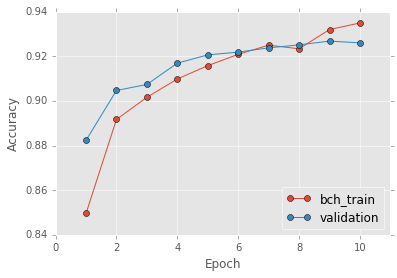

In [14]:
# Save performance data figure
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(np.arange(epochs)+1, metricRecords.accs, '-o', label='bch_train')
plt.plot(np.arange(epochs)+1, metricRecords.val_accs, '-o', label='validation')
plt.xlim(0, epochs+1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('notMNIST_cnn10.png')
plt.show()